## POS_CASH_balance

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
save_files = True

In [3]:
# load cash file
df_cash = pd.read_csv('input/POS_CASH_balance.csv')
df_cash.info()
display(df_cash.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int64
SK_ID_CURR               int64
MONTHS_BALANCE           int64
CNT_INSTALMENT           float64
CNT_INSTALMENT_FUTURE    float64
NAME_CONTRACT_STATUS     object
SK_DPD                   int64
SK_DPD_DEF               int64
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [4]:
df_cash.NAME_CONTRACT_STATUS.replace({'Returned to the store':'Returned',
                                      'Amortized debt':'Amortized',
                                      'XNA':np.nan},
                                     inplace=True)

display(df_cash.NAME_CONTRACT_STATUS.value_counts())

df_cash.sort_values(by=['SK_ID_PREV','MONTHS_BALANCE'],inplace=True)
df_cash.reset_index(drop=True,inplace=True)

df_cash.rename(columns={'MONTHS_BALANCE':'MONTH',
                        'CNT_INSTALMENT':'CNT_INST',
                        'CNT_INSTALMENT_FUTURE':'FUTURE_INST',
                        'NAME_CONTRACT_STATUS':'STATUS',
                        'SK_DPD':'DPD',
                        'SK_DPD_DEF':'DPD_DEF'},
               inplace=True)

id_prev_to_curr = df_cash.groupby('SK_ID_PREV').SK_ID_CURR.first()
df_cash.drop('SK_ID_CURR',axis=1,inplace=True)

df_cash = pd.get_dummies(df_cash)

df_cash.head()

Active       9151119
Completed     744883
Signed         87260
Demand          7065
Returned        5461
Approved        4917
Amortized        636
Canceled          15
Name: NAME_CONTRACT_STATUS, dtype: int64

,SK_ID_PREV,MONTH,CNT_INST,FUTURE_INST,DPD,DPD_DEF,STATUS_Active,STATUS_Amortized,STATUS_Approved,STATUS_Canceled,STATUS_Completed,STATUS_Demand,STATUS_Returned,STATUS_Signed
0,1000001,-10,12.0,12.0,0,0,1,0,0,0,0,0,0,0
1,1000001,-9,12.0,11.0,0,0,1,0,0,0,0,0,0,0
2,1000001,-8,2.0,0.0,0,0,0,0,0,0,1,0,0,0
3,1000002,-54,4.0,4.0,0,0,1,0,0,0,0,0,0,0
4,1000002,-53,6.0,3.0,0,0,1,0,0,0,0,0,0,0


In [5]:
agg_funcs = {
    'MONTH':['min','max','count'],
    'CNT_INST':['min','max','first','last'],
    'FUTURE_INST':['min','max','first','last'],
    'DPD':['min','max','first','last','mean'],
    'DPD_DEF':['min','max','first','last','mean'],
    'STATUS_Active':['min','max','first','last','mean'],
    'STATUS_Completed':['min','max','first','last','mean'],
    'STATUS_Signed':['min','max','first','last','mean'],
    'STATUS_Demand':['min','max','first','last','mean'],
    'STATUS_Returned':['min','max','first','last','mean'],
    'STATUS_Approved':['min','max','first','last','mean'],
    'STATUS_Amortized':['min','max','first','last','mean'],
    'STATUS_Canceled':['min','max','first','last','mean'],
}

cash_grouped = df_cash.groupby('SK_ID_PREV').agg(agg_funcs)

cash_grouped.columns = ['POS_'+'_'.join(x) for x in cash_grouped.columns.values]

del df_cash

cash_grouped.head()

,POS_MONTH_min,POS_MONTH_max,POS_MONTH_count,POS_CNT_INST_min,POS_CNT_INST_max,POS_CNT_INST_first,POS_CNT_INST_last,POS_FUTURE_INST_min,POS_FUTURE_INST_max,POS_FUTURE_INST_first,...,POS_STATUS_Amortized_min,POS_STATUS_Amortized_max,POS_STATUS_Amortized_first,POS_STATUS_Amortized_last,POS_STATUS_Amortized_mean,POS_STATUS_Canceled_min,POS_STATUS_Canceled_max,POS_STATUS_Canceled_first,POS_STATUS_Canceled_last,POS_STATUS_Canceled_mean
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,
1000001,-10,-8,3,2.0,12.0,12.0,2.0,0.0,12.0,12.0,...,0,0,0,0,0.0,0,0,0,0,0.0
1000002,-54,-50,5,4.0,6.0,4.0,4.0,0.0,4.0,4.0,...,0,0,0,0,0.0,0,0,0,0,0.0
1000003,-4,-1,4,12.0,12.0,12.0,12.0,9.0,12.0,12.0,...,0,0,0,0,0.0,0,0,0,0,0.0
1000004,-29,-22,8,7.0,10.0,10.0,7.0,0.0,10.0,10.0,...,0,0,0,0,0.0,0,0,0,0,0.0
1000005,-56,-46,11,10.0,10.0,10.0,10.0,0.0,10.0,10.0,...,0,0,0,0,0.0,0,0,0,0,0.0


In [6]:
cash_grouped['SK_ID_CURR'] = id_prev_to_curr

cash_idcurr = cash_grouped.groupby('SK_ID_CURR').agg(['min','max','sum','mean'])
cash_idcurr['POS_CNT'] = id_prev_to_curr.value_counts()

cash_idcurr.columns = ['_'.join(x) for x in cash_idcurr.columns.values]
cash_cols = cash_idcurr.columns

del cash_grouped

cash_idcurr.head()

,POS_MONTH_min_min,POS_MONTH_min_max,POS_MONTH_min_sum,POS_MONTH_min_mean,POS_MONTH_max_min,POS_MONTH_max_max,POS_MONTH_max_sum,POS_MONTH_max_mean,POS_MONTH_count_min,POS_MONTH_count_max,...,POS_STATUS_Canceled_first_mean,POS_STATUS_Canceled_last_min,POS_STATUS_Canceled_last_max,POS_STATUS_Canceled_last_sum,POS_STATUS_Canceled_last_mean,POS_STATUS_Canceled_mean_min,POS_STATUS_Canceled_mean_max,POS_STATUS_Canceled_mean_sum,POS_STATUS_Canceled_mean_mean,POS_CNT_
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-96,-57,-153,-76.500000,-93,-53,-146,-73.0,4,5,...,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,2
100002,-19,-19,-19,-19.000000,-1,-1,-1,-1.0,19,19,...,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1
100003,-77,-25,-130,-43.333333,-66,-18,-105,-35.0,8,12,...,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,3
100004,-27,-27,-27,-27.000000,-24,-24,-24,-24.0,4,4,...,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1
100005,-25,-25,-25,-25.000000,-15,-15,-15,-15.0,11,11,...,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,1


In [7]:
print('loading train...')
df_train = pd.read_csv('input/application_train.csv',index_col='SK_ID_CURR')

print('merging train...')
df_train = df_train.merge(cash_idcurr,how='left',left_index=True,right_index=True)

if save_files:
    print('saving train...')
    df_train[cash_cols].to_csv('input/app_train_ALL_pos.csv')
    
    print('loading test...')
    df_test = pd.read_csv('input/application_test.csv',index_col='SK_ID_CURR')

    print('merging test...')
    df_test = df_test.merge(cash_idcurr,how='left',left_index=True,right_index=True)
   
    print('saving test...')
    df_test[cash_cols].to_csv('input/app_test_ALL_pos.csv')
    
del cash_idcurr

display(df_train.head())

print('Done!')

loading train...
merging train...
saving train...
loading test...
merging test...
saving test...


,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,POS_STATUS_Canceled_first_mean,POS_STATUS_Canceled_last_min,POS_STATUS_Canceled_last_max,POS_STATUS_Canceled_last_sum,POS_STATUS_Canceled_last_mean,POS_STATUS_Canceled_mean_min,POS_STATUS_Canceled_mean_max,POS_STATUS_Canceled_mean_sum,POS_STATUS_Canceled_mean_mean,POS_CNT_
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


Done!


## model

In [8]:
def plot_roc_curve(y_true, y_pred, color='darkorange',plot_random=True,label='ROC curve'):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    score = roc_auc_score(y_true, y_pred)
    
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=label+' (area = %0.2f)' % score)
    
    if plot_random:
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

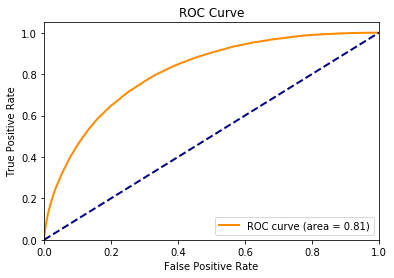

In [9]:
target_counts = df_train.TARGET.value_counts()
targ1_weight = target_counts[0]/target_counts[1]
weights = df_train.TARGET.replace({0:1, 1:targ1_weight}).values

dtypes = df_train.dtypes
cols_categ = dtypes[dtypes=='object'].index.tolist()
for col in cols_categ:
    df_train[col] = df_train[col].astype('category')
    
y_true = df_train.TARGET
X = df_train.drop('TARGET',axis=1)
train_data = lgb.Dataset(X, label=y_true, weight=weights)

    
# train
param = {'objective':'binary', 'metric':'auc'}
bst = lgb.train(param, train_data)

#plot roc curve
plt.figure()
plot_roc_curve(y_true, bst.predict(X))

EXT_SOURCE_3                   0.254827
EXT_SOURCE_2                   0.197884
ORGANIZATION_TYPE              0.101392
EXT_SOURCE_1                   0.068462
AMT_CREDIT                     0.024484
OCCUPATION_TYPE                0.022362
DAYS_BIRTH                     0.020504
AMT_GOODS_PRICE                0.019522
DAYS_EMPLOYED                  0.017049
AMT_ANNUITY                    0.016875
NAME_EDUCATION_TYPE            0.016820
CODE_GENDER                    0.015295
OWN_CAR_AGE                    0.013632
POS_STATUS_Active_mean_sum     0.010135
POS_CNT_INST_max_mean          0.009998
DAYS_ID_PUBLISH                0.008045
POS_DPD_DEF_max_mean           0.007815
POS_MONTH_max_max              0.007762
POS_FUTURE_INST_min_mean       0.006354
NAME_CONTRACT_TYPE             0.005953
FLAG_DOCUMENT_3                0.005791
NAME_FAMILY_STATUS             0.005728
POS_FUTURE_INST_first_mean     0.005506
POS_DPD_mean_min               0.004575
DAYS_LAST_PHONE_CHANGE         0.004543


Text(0,0.5,'cumulative frac gain')

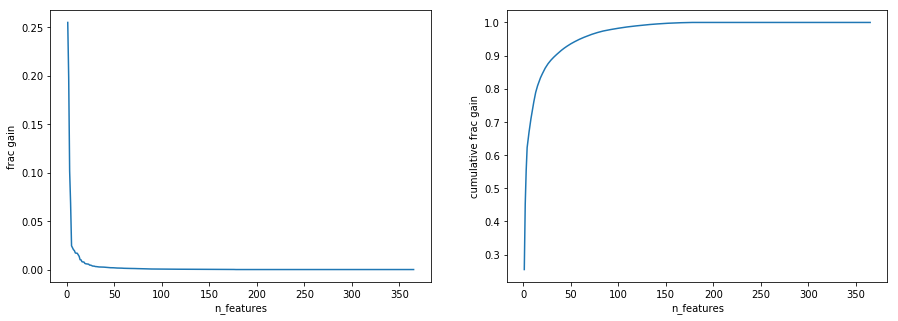

In [10]:
plt.figure(figsize=(10,30))

feat_imp = pd.DataFrame({'split':bst.feature_importance(importance_type='split'),
                         'gain':bst.feature_importance(importance_type='gain')},
                        index=bst.feature_name())

total_gain = feat_imp['gain'].sum()
frac_gain = feat_imp['gain']/total_gain
frac_gain = frac_gain.sort_values(ascending=False)

display(frac_gain.head(30))

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(len(frac_gain))+1, frac_gain)
plt.xlabel('n_features')
plt.ylabel('frac gain')

plt.subplot(1,2,2)
plt.plot(np.arange(len(frac_gain))+1,frac_gain.cumsum())
plt.xlabel('n_features')
plt.ylabel('cumulative frac gain')

In [12]:
# select top n columns from pos_cash by importance
n_cols = 60
select_cols = frac_gain[frac_gain.index.str.contains('POS_')].index[:n_cols]

if save_files:
    df_train[select_cols].to_csv('input/app_train_SELECT_pos.csv')
    df_test[select_cols].to_csv('input/app_test_SELECT_pos.csv')
    
frac_gain[select_cols]

POS_STATUS_Active_mean_sum        0.010135
POS_CNT_INST_max_mean             0.009998
POS_DPD_DEF_max_mean              0.007815
POS_MONTH_max_max                 0.007762
POS_FUTURE_INST_min_mean          0.006354
POS_FUTURE_INST_first_mean        0.005506
POS_DPD_mean_min                  0.004575
POS_CNT_INST_first_mean           0.004202
POS_MONTH_count_sum               0.003567
POS_MONTH_min_min                 0.003463
POS_MONTH_max_sum                 0.003105
POS_FUTURE_INST_min_max           0.002654
POS_MONTH_max_min                 0.002633
POS_DPD_DEF_mean_mean             0.002589
POS_MONTH_count_mean              0.002499
POS_FUTURE_INST_max_mean          0.002484
POS_CNT_INST_max_max              0.002328
POS_CNT_INST_first_max            0.002088
POS_MONTH_min_sum                 0.001983
POS_STATUS_Active_mean_mean       0.001881
POS_MONTH_min_mean                0.001824
POS_STATUS_Completed_mean_sum     0.001728
POS_MONTH_min_max                 0.001649
POS_DPD_DEF